In [224]:
import sys
sys.path.append("C:/Users/User/Desktop/hopfield-izhikevich/hopfield")
from hopfield import Hopfield
# import hopfield

In [329]:
import json
import jsonlines
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from pprint import pprint
from tqdm.notebook import tqdm
from typing import Callable
import numpy
import itertools as it

In [470]:
def load_dir(dataset: list, path: str, label: bool, sort=True):
    dataset.sort(key=lambda e: e["id"])
    if dataset:
        index = dataset[-1]["id"]+1
    else:
        index = 0
    fnames = [(path+"/Red/"+i[:2]+"_Red.txt", path+"/Green/"+i[:2]+"_Green.txt",path+"/Blue/"+i[:2]+"_Blue.txt") for i in [i for i in os.walk(path)][1][2]]
    for fname in fnames:
        person = {"id": index}
        person["label"] = label
        with open(fname[0],"r") as rfile, open(fname[1],"r") as gfile, open(fname[2],"r") as bfile:
            person["r"] = [float(i) for i in rfile.readlines()[1:]]
            person["g"] = [float(i) for i in gfile.readlines()[1:]]
            person["b"] = [float(i) for i in bfile.readlines()[1:]]
        
        if sort:
            person["r"].sort()
            person["g"].sort()            
            person["b"].sort()
        
        index+=1
        dataset.append(person)
        
def load_dataset(dataset: list, path: str, pathpos: str, pathneg: str, sort=True):
    load_dir(dataset, path+"/"+pathpos, True, sort=sort)
    load_dir(dataset, path+"/"+pathneg, False, sort=sort)    
        
        
# def get_filter(dataset: list, filter: str):
#     if filter!="r" and filter!="g" and filter!="b":
#         raise ValueError('Wrong filter: must be "r", "g", "b"')
#     new_dataset = []
#     for person in dataset:
#         new_dataset.append({"id": person["id"], "label": person["label"], "data": person[filter]})
    
#     return new_dataset

def show_plot_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for i in np.arange(0,len(dataset), 1):
        color="green"
        if dataset[i]["label"]:
            color="red"
        for j in dataset[i][filter]:
            plt.plot(i,j, "o", markersize=0.5, color=color)
    plt.show()

    
def binarize_person(person: dict, precision=1e-3, up=1.8, down=0.2, radius=0, flatten=True, filters=3):
    person_data = np.zeros((3, int((up-down)//precision)+1), np.float32)[0:filters]
    
    dots  = (
        ((np.array(person["r"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["g"]).clip(down, up)-down)//precision).astype(np.uint32),
        ((np.array(person["b"]).clip(down, up)-down)//precision).astype(np.uint32))[0:filters]
#     r = np.array(person["r"])
#     g = np.array(person["g"])
#     b = np.array(person["b"])
    
    
#     dots  = (
#         ((r[up>r & r>down]-down)//precision).astype(np.uint32),
#         (([up>g & g>down]-down)//precision).astype(np.uint32),
#         (([up>b & b>down]-down)//precision).astype(np.uint32))[0:filters]
    
    
    
    for color_index in range(filters):
        for dot in dots[color_index]:
            person_data[color_index][max(0, dot-radius) : min(dot+radius+1, person_data.shape[1])].fill(1)
    
    if flatten:
        return {"id": person["id"], "label": person["label"], "data": person_data.flatten()}
    else:
        return {"id": person["id"], "label": person["label"], "data": person_data}

def show_plot_avg_by_filter(dataset: list, filter: str):
    plt.clf()
    if filter!="r" and filter!="g" and filter!="b":
        raise ValueError('Wrong filter: must be "r", "g", "b"')
    for person in dataset:
        
        if person["label"]:
            color="red"
            x = 0
        else:
            color="green"
            x = 1
             
        for y in person[filter]:
            plt.plot(x,y, "o", markersize=0.5, color=color)
    plt.show()
    


In [462]:
def diceScore(a: np.ndarray, b: np.ndarray):
    if(len(a)!=len(b)):
        raise IndexError 
    tp = 0
    for i in range(min(len(a), len(b))):
        if a[i]>0 and b[i]>0:
            tp+=1
    return 2*tp/(sum(a>0)+sum(b>0))

In [463]:
def fullMatch(a: np.ndarray, b: np.ndarray):
    if(len(a)!=len(b)):
        raise IndexError 
    tp = 0
    for i in range(min(len(a), len(b))):
        if (a[i]>0 and b[i]>0) or (a[i]<0 and b[i]<0):
            tp+=1
    return tp/(len(a))

In [454]:
diceScore(np.array([1,1,1,1,-1]),np.array([1,-1,-1,1,-1]))

0.6666666666666666

In [455]:
def max_score_i(dataset: np.ndarray, X: np.ndarray, i: int, score_fn: Callable):
    if i==0:
        max_i = 1
    else:
        max_i = 0
    # print(f"len {len(dataset)}")
    for j in (k for k in range(len(dataset)) if k!=i):
        if score_fn(X,dataset[max_i]) <= score_fn(X,dataset[j]):
            max_i = j
            
    return max_i

In [456]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [482]:
dataset = []
load_dataset(dataset, "data_orig/Data", "BC", "Control")

## One-leave-out with dice score

In [483]:
q_range=(0,0.9,10)
r_range=(0,5,6)
q = np.linspace(*q_range)
r = np.linspace(*r_range,dtype=int)
tests = list(it.product(q,r))
_dataset=dataset[39:]

In [476]:
filters=1

time=500
dtype=np.float32

outputs=[]

for q,r in tqdm(tests):
    result = []
    answer = []
    maxs = []
    dataset_bin = [binarize_person(p, precision=1e-3, radius=r, filters=filters, down=0.4, up=1.6) for p in _dataset]
    raw_data = np.array([i["data"]*2-1 for i in dataset_bin], dtype=dtype)

    for i in tqdm(range(len(_dataset))):
        model = Hopfield(q=q, np_type=dtype)
        _mask = np.ones(len(dataset_bin), dtype=bool)
        _mask[i] = False

        _X = raw_data[i]
        _images = raw_data[_mask]


        model.train(images=_images, zeroDiagonal=True)
        out = model.run(X=_X, time=time)


        max_i = max_score_i(dataset=raw_data, X=out["output"], i=i, score_fn=diceScore)
        maxs.append(max_i)


        answer.append(dataset_bin[max_i]["label"])
        if dataset_bin[max_i]["label"]==dataset_bin[i]["label"]:
            result.append(1)
        else:
            result.append(0)
            
    score = sum(result)/len(_dataset)
    outputs.append({"qr":(q,r), "score":score, "result":result})
    print("qr",(q,r), " score ",score)
    

print(outputs)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

qr (0.0, 0)  score  1.0


  0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: 

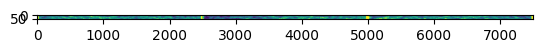

(58, 7500)
coef: 0.007733333333333333


  0%|          | 0/58 [00:00<?, ?it/s]

8 8 17 8 17 17 8 8 17 17 8 

In [ ]:
q=0
radius=25
#0 25 0.65 10-4

filters=3

time=500
dtype=np.float32

result = []
answer = []
maxs = []

dataset_bin = [binarize_person(p, precision=1e-4, radius=radius, filters=filters, down=0.8, up=1.05) for p in _dataset]
raw_data = np.array([i["data"]*2-1 for i in dataset_bin], dtype=dtype)

plt.imshow(raw_data)
plt.show()
print(raw_data.shape)
print(f"coef: {raw_data.shape[0]/raw_data.shape[1]}")


for i in tqdm(range(len(_dataset))):
    model = Hopfield(q=q, np_type=dtype)
    _mask = np.ones(len(dataset_bin), dtype=bool)
    _mask[i] = False

    _X = raw_data[i]
    _images = raw_data[_mask]

    
    model.train(images=_images, zeroDiagonal=True)
    out = model.run(X=_X, time=time)
    
    max_i = max_score_i(dataset=raw_data, X=out["output"], i=i, score_fn=diceScore)
    maxs.append(max_i)
    
    print(max_i, end=" ")
    
    answer.append(dataset_bin[max_i]["label"])
    if dataset_bin[max_i]["label"]==dataset_bin[i]["label"]:
        result.append(1)
    else:
        result.append(0)
    
print("")
score = sum(result)/len(_dataset)
print(score)

In [313]:
result

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [309]:
answer

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [23]:
# for i in tqdm(range(len(dataset_bin))):
#     _mask = np.ones(len(dataset_bin), dtype=bool)
#     _mask[i] = False

#     _X = dataset_bin[i]["data"]*2-1
#     _images = raw_data[_mask]*2-1
    
#     model = Hopfield(q=q, np_type=np.float32)
#     model.train(images=_images)
#     # print("trained")
#     output = model.run(X=_X, time=time)
    
#     output["output"] = (output["output"] + 1)*2
#     for j in range(len(dataset_bin)-1):
#         if (raw_data[_mask][j]==output["output"]).all():
#             if i>j:
#                 if dataset_bin[i]["label"]==dataset_bin[j]["label"]:
#                     print("match")
#                     pos+=1
#                     break
#             elif dataset_bin[i]["label"]==dataset_bin[j+1]["label"]:
#                 print("match")
#                 pos+=1
#                 break
            
        
# print(pos)